In [1]:
import pandas as pd
import numpy as np
import random
import os
from sklearn.preprocessing import OneHotEncoder
from neural_network_wrapper import NeuralNetworkWrapper
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
import optimizers

import json

In [2]:
data_simple_train_100 = pd.read_csv("./projekt1/classification/data.simple.train.100.csv")
data_simple_train_500 = pd.read_csv("./projekt1/classification/data.simple.train.500.csv")
data_simple_train_1000 = pd.read_csv("./projekt1/classification/data.simple.train.1000.csv")
data_simple_train_10000 = pd.read_csv("./projekt1/classification/data.simple.train.10000.csv")

data_simple_test_100 = pd.read_csv("./projekt1/classification/data.simple.test.100.csv")
data_simple_test_500 = pd.read_csv("./projekt1/classification/data.simple.test.500.csv")
data_simple_test_1000 = pd.read_csv("./projekt1/classification/data.simple.test.1000.csv")
data_simple_test_10000 = pd.read_csv("./projekt1/classification/data.simple.test.10000.csv")

In [3]:
def prepare_data_simple(train_data, test_data):
    
    X_train = np.array(train_data.loc[:, ['x', 'y']])
    y_train = train_data.cls
    y_train -= 1
#     #one hot encoding
#     y_ohc = np.zeros((y_train.size, int(np.max(y_train))+1))
#     y_ohc[np.arange(y_train.size),y_train.astype(np.int)] = 1
#     y_train = y_ohc
    y_train = np.array(y_train)
    X_test = np.array(test_data.loc[:, ['x', 'y']])
    y_test = test_data.cls
    y_test -= 1
    y_test = np.array(y_test)
    #one hot encoding
#     y_ohc = np.zeros((y_test.size, int(np.max(y_test))+1))
#     y_ohc[np.arange(y_test.size),y_test.astype(np.int)] = 1
#     y_test = y_ohc
    
    
    # Are we supposed to use StandardScaler?
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    
    return {"X_train": X_train,
           "X_test": X_test,
           "y_train": y_train,
           "y_test": y_test}

In [4]:
data = [{"dataset name": "Data simple 100 obs",
        "data": prepare_data_simple(data_simple_train_100, data_simple_test_100)},
       {"dataset name": "Data simple 500 obs",
        "data": prepare_data_simple(data_simple_train_500, data_simple_test_500)},
       {"dataset name": "Data simple 1000 obs",
        "data": prepare_data_simple(data_simple_train_1000, data_simple_test_1000)},
       {"dataset name": "Data simple 10000 obs",
        "data": prepare_data_simple(data_simple_train_10000, data_simple_test_10000)}]

In [5]:
def perform_experiment(dataset,
                       d,
                       exp_objective,
                       exp_values,
                       num_reps):
    """
    """
    X_train = dataset['X_train']
    y_train = dataset['y_train']
    X_test = dataset['X_test']
    y_test = dataset['y_test']

    d = d.copy()
    
    for k in exp_values.keys():
        d[k] = {}
        d[k]['test_accuracy'] = []
    
    for i in range(num_reps):
        #print(f"Experiment {i+1}/{num_reps}")
    
        # reproducibility issues
        random.seed(d['seed'] + i)
        np.random.seed(d['seed'] + i)
    
        # testing learning rate
        for k, v in exp_values.items():
            if exp_objective == 'lr':

                NN = NeuralNetworkWrapper(d['input_dim'],
                                      d['neuron_numbers'],
                                      ['relu'] * (len(d['neuron_numbers']) - 1) + d['output_activation'],
                                      d['loss_function'],
                                      v,
                                      optimizers.Optimizer(),
                                      d['batch_size'])
            
            elif exp_objective == 'activation_function':
                
                NN = NeuralNetworkWrapper(d['input_dim'],
                                          d['neuron_numbers'],
                                          v * (len(d['neuron_numbers']) - 1) + d['output_activation'],
                                          d['loss_function'],
                                          d['learning_rate'],
                                          optimizers.Optimizer(),
                                          d['batch_size'])
            
            elif exp_objective == 'inertia':
                
                NN = NeuralNetworkWrapper(d['input_dim'],
                                          d['neuron_numbers'],
                                          ['relu'] * (len(d['neuron_numbers']) - 1) + d['output_activation'],
                                          d['loss_function'],
                                          d['learning_rate'],
                                          optimizers.GDwithMomentum(v),
                                          d['batch_size'])
            
            elif exp_objective == 'batch_size':
                
                NN = NeuralNetworkWrapper(d['input_dim'],
                                          d['neuron_numbers'],
                                          ['relu'] * (len(d['neuron_numbers']) - 1) + d['output_activation'],
                                          d['loss_function'],
                                          d['learning_rate'],
                                          optimizers.Optimizer(),
                                          v)
            
                
            NN.train(X_train,
                     y_train,
                     d['num_epochs'],
                     validation_split = 0,
                     test_accuracy=(X_test, y_test),
                     verbosity=False)
                
            d[k]['test_accuracy'].append(NN.test_accuracy)

    for k in exp_values.keys():
        # aggregating results
        d[k]['test_accuracy_mean'] = np.mean(np.array(d[k]['test_accuracy']).T, axis=1)
        d[k]['test_accuracy_std'] = np.std(np.array(d[k]['test_accuracy']).T, axis=1)

        d[k] = {"Accuracy": d[k]['test_accuracy_mean'],
               "Accuracy std": d[k]['test_accuracy_std'],
               "Best Accuracy": np.max(d[k]['test_accuracy_mean']),
               "Best Accuracy std": d[k]['test_accuracy_std'][np.argmax(d[k]['test_accuracy_mean'])]}

    return {k: d[k] for k in exp_values.keys()}


In [6]:
def experiments_pipeline(data,
                         experiment_dict,
                         experiments,
                         num_reps=1,
                         save_to_file=False):
    """
    """
    d = experiment_dict.copy()
    output = {'lr':{},
             'activation_function':{},
             'inertia':{},
             'batch_size':{}}
    # Experiments for each dataset
    for dataset in data:
        print("------ Dataset name: {}".format(dataset['dataset name']))
        output['lr'][dataset['dataset name']] = perform_experiment(dataset['data'],
                                                     experiment_dict,
                                                     'lr',
                                                     experiments['lr'],
                                                     num_reps)
        output['activation_function'][dataset['dataset name']] = perform_experiment(dataset['data'],
                                                        experiment_dict,
                                                        'activation_function',
                                                        experiments['activation_function'],
                                                        num_reps)
        
        output['inertia'][dataset['dataset name']] = perform_experiment(dataset['data'],
                                                        experiment_dict,
                                                        'inertia',
                                                        experiments['inertia'],
                                                        num_reps)
        
        output['batch_size'][dataset['dataset name']] = perform_experiment(dataset['data'],
                                                        experiment_dict,
                                                        'batch_size',
                                                        experiments['batch_size'],
                                                        num_reps)
        
        
        
    return output

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style("white")
#sns.despine(left=True, bottom=True)



# Available matplotlib styles:
# ['seaborn-colorblind', 'fast', 'seaborn-deep', 'fivethirtyeight', 'seaborn',
#  'Solarize_Light2', 'seaborn-talk', 'seaborn-darkgrid', 'ggplot', 'seaborn-bright',
#  'seaborn-paper', 'seaborn-pastel', 'bmh', 'seaborn-dark', 'seaborn-notebook',
#  'tableau-colorblind10', 'seaborn-white', '_classic_test', 'seaborn-ticks',
#  'seaborn-poster', 'seaborn-muted', 'dark_background', 'grayscale',
#  'seaborn-dark-palette', 'seaborn-whitegrid', 'classic']

def visualize_experiment(d, title="", figsize=(21, 12)):
    
    plt.style.use('_classic_test')
    plt.style.use('seaborn-white')
    fig, a = plt.subplots(2, 2)
    fig.set_figwidth(figsize[0])
    fig.set_figheight(figsize[1])
    dataset_names = list(d.keys())
    
    fig.suptitle(title, fontsize=30)
    
    counter = 0
    for i in range(2):
        for j in range(2):
            
            subplot_dict = d[dataset_names[counter]]
            
            a[i][j].title.set_text(f'Accuracy in {dataset_names[counter]}')
            a[i][j].set_ylim((0, 1))
            a[i][j].set_xticks(range(1, 1 + len(subplot_dict[list(subplot_dict.keys())[0]]['Accuracy'])))
            
            a[i][j].set_xlabel('Epoch')
            a[i][j].set_ylabel('Accuracy')
            
            for k, v in subplot_dict.items():
                a[i][j].errorbar([it+1 for it in range(len(v['Accuracy']))],
                                 v['Accuracy'],
                                 yerr=v['Accuracy std'],
                                 linestyle='--',
                                 marker='o',
                                 label=k)

                
                
                a[i][j].legend(loc="lower right")
            
            counter += 1
    
    
    # Experiment report
    dataset_names = []
    x = {}
    for dataset_name, exp_results in d.items():
        dataset_names.append(dataset_name)

        for k, v in exp_results.items():
            try:
                x[k].append("{:.2f} +- {:.2f}".format(v['Best Accuracy'], v['Best Accuracy std']))
            except:
                x[k] = ["{:.2f} +- {:.2f}".format(v['Best Accuracy'], v['Best Accuracy std'])]

    y = pd.DataFrame(x)
    y.index = dataset_names
    y.transpose()
    
    return y, fig # returns dataframe with results & figure

In [8]:
# CETERIS PARIBUS NETWORK ARCHITECTURE 
experiment_dict = {
    "input_dim" : 2,
    "neuron_numbers" : [2, 1], # number of neurons in consecutive layers
    "activation_functions" : ['relu'],
    "loss_function" : 'logistic_loss',
    "batch_size" : 64,
    "num_epochs" : 2,
    "seed" : 42,
    "output_activation" : ['sigmoid'],
    "learning_rate" : 0.01
}

experiments = {'lr':
                   {'lr=0.0001' : 0.0001,
                    'lr=0.001' : 0.001,
                    'lr=0.01' : 0.01,
                    'lr=0.1' : 0.1},
               'activation_function': 
                   {'relu' : ['relu'],
                    'leaky relu' : ['leaky_relu'],
                   'sigmoid': ['sigmoid'],
                   'tanh': ['tanh']},
               'inertia' : 
                   {'beta=0' : 0,
                    'beta=0.5' : 0.5,
                    'beta=0.9' : 0.9},
               'batch_size' : 
                   {'bs=4' : 4,
                    'bs=16' : 16,
                    'bs=32' : 32,
                    'bs=64' : 64}
              }

In [9]:
ans = experiments_pipeline(data, experiment_dict, experiments, num_reps=2)

------ Dataset name: Data simple 100 obs
[0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0
 1 0 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 0
 0 0 1 1 0 1 0 0 1 0 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1]
[1 1 1 0 1 1 0 1 1 1 0 1 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 1 0
 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1
 1 1 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 0]
[0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0
 1 0 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 0
 0 0 1 1 0 1 0 0 1 0 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1]
[1 1 1 0 1 1 0 1 1 1 0 1 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 1 0
 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1
 1 1 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 0]
Final loss: 1.052
[0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0
 1 0 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1

[0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1 1 1 0 0 0 1 1 0 0 1 1 0 1 0
 1 0 1 0 1 1 1 0 1 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 0
 0 0 1 0 0 0 1 1 1 1 0 1 0 0 0 1 1 1 0 0 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0
 0 1 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 0
 0 1 1 0 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 0 0 0
 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1
 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 0 1 0 1 1 1 1 1 0 0 1 1
 1 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 1 1 1 0
 0 1 0 0 1 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0
 1 1 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1
 1 0 0 0 0 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1
 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 1 0 0 0 1 1 0 1 1 0 1 0 0 1 1 0 0 1
 0 1 0 1 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 1 1 0 1 1 0 1 0 0 1 0 1 0
 1 0 1 1 0 1 1 1 0 0 0 1 

[0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1 1 1 0 0 0 1 1 0 0 1 1 0 1 0
 1 0 1 0 1 1 1 0 1 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 0
 0 0 1 0 0 0 1 1 1 1 0 1 0 0 0 1 1 1 0 0 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0
 0 1 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 0
 0 1 1 0 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 0 0 0
 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1
 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 0 1 0 1 1 1 1 1 0 0 1 1
 1 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 1 1 1 0
 0 1 0 0 1 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0
 1 1 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1
 1 0 0 0 0 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1
 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 1 0 0 0 1 1 0 1 1 0 1 0 0 1 1 0 0 1
 0 1 0 1 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 1 1 0 1 1 0 1 0 0 1 0 1 0
 1 0 1 1 0 1 1 1 0 0 0 1 

[0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 0 1 0 1
 1 1 0 1 1 0 1 1 1 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0
 0 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1
 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1
 1 0 1 0 0 0 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 0 0 0 1 0 0 1 1 0
 0 0 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 1 0 0 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0
 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1
 0 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1
 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 1 1 1 0 0 0 1 0 1
 0 0 1 1 1 1 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 1 1 1 1 1 0 0 1 1 0 1
 0 1 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 0
 0 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0 0 1 0 0 1
 1 0 0 1 0 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 1 1 0 0 1
 1 1 0 0 0 0 0 1 0 1 1 1 

[0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 0 1 0 1
 1 1 0 1 1 0 1 1 1 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0
 0 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1
 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 1
 1 0 1 0 0 0 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 0 0 0 1 0 0 1 1 0
 0 0 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 1 0 0 1 1 1 0 1 0 0 1 1 0 1 1 1 0 1 0
 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1
 0 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1
 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 1 1 1 0 0 0 1 0 1
 0 0 1 1 1 1 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 1 1 1 1 1 0 0 1 1 0 1
 0 1 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 0
 0 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0 0 1 0 0 1
 1 0 0 1 0 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 1 1 0 0 1
 1 1 0 0 0 0 0 1 0 1 1 1 

[0 0 0 ... 0 0 1]
[1 1 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[1 1 0 ... 0 0 0]
Final loss: 0.991
[0 0 0 ... 0 0 1]
[1 1 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[1 1 0 ... 0 0 0]
Final loss: 0.868
[0 0 0 ... 0 0 1]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[1 0 0 ... 0 1 0]
Final loss: 0.568
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 1 1]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 1 1]
Final loss: 0.060
[0 0 0 ... 0 0 1]
[1 1 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[1 1 0 ... 0 0 0]
Final loss: 0.991
[0 0 0 ... 0 0 1]
[1 1 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[1 1 0 ... 0 0 0]
Final loss: 0.868
[0 0 0 ... 0 0 1]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[1 0 0 ... 0 1 0]
Final loss: 0.568
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 1 1]
[0 0 0 ... 0 0 1]
[0 0 0 ... 0 1 1]
Final loss: 0.060
[0 0 0 ... 0 0 1]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[1 0 0 ... 0 1 0]
Final loss: 0.568
[0 0 0 ... 0 0 1]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 1]
[1 0 0 ... 0 1 0]
Final loss: 0.544
[0 0 0 ... 0 0 1]
[1 1 1 ... 1 1 0]
[0 0 0 ... 0 0 1]
[1 0 0 ... 0 1 0]
Final loss: 0.613
[0 0 0 ...

(                          lr=0.0001      lr=0.001       lr=0.01        lr=0.1
 Data simple 100 obs    0.00 +- 0.00  0.00 +- 0.00  0.00 +- 0.00  0.00 +- 0.00
 Data simple 500 obs    0.00 +- 0.00  0.00 +- 0.00  0.00 +- 0.00  0.00 +- 0.00
 Data simple 1000 obs   0.00 +- 0.00  0.00 +- 0.00  0.00 +- 0.00  0.00 +- 0.00
 Data simple 10000 obs  0.00 +- 0.00  0.00 +- 0.00  0.00 +- 0.00  0.00 +- 0.00,
 <Figure size 1680x960 with 4 Axes>)

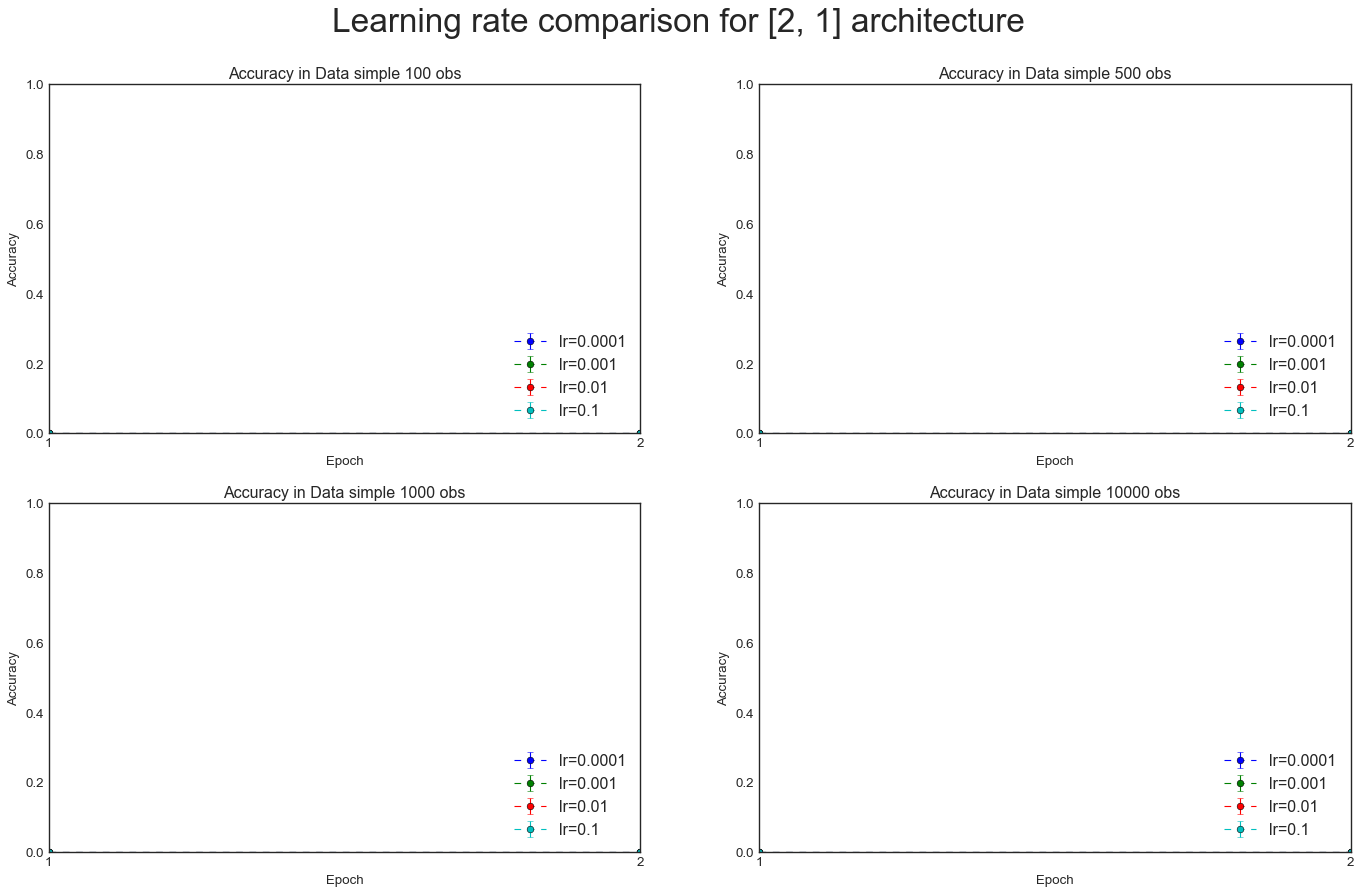

In [10]:
visualize_experiment(ans['lr'],
                     title='Learning rate comparison for {} architecture'.format(str(experiment_dict['neuron_numbers'])))

(                               relu    leaky relu       sigmoid          tanh
 Data simple 100 obs    0.00 +- 0.00  0.00 +- 0.00  0.00 +- 0.00  0.00 +- 0.00
 Data simple 500 obs    0.00 +- 0.00  0.00 +- 0.00  0.00 +- 0.00  0.00 +- 0.00
 Data simple 1000 obs   0.00 +- 0.00  0.00 +- 0.00  0.00 +- 0.00  0.00 +- 0.00
 Data simple 10000 obs  0.00 +- 0.00  0.00 +- 0.00  0.00 +- 0.00  0.00 +- 0.00,
 <Figure size 1680x960 with 4 Axes>)

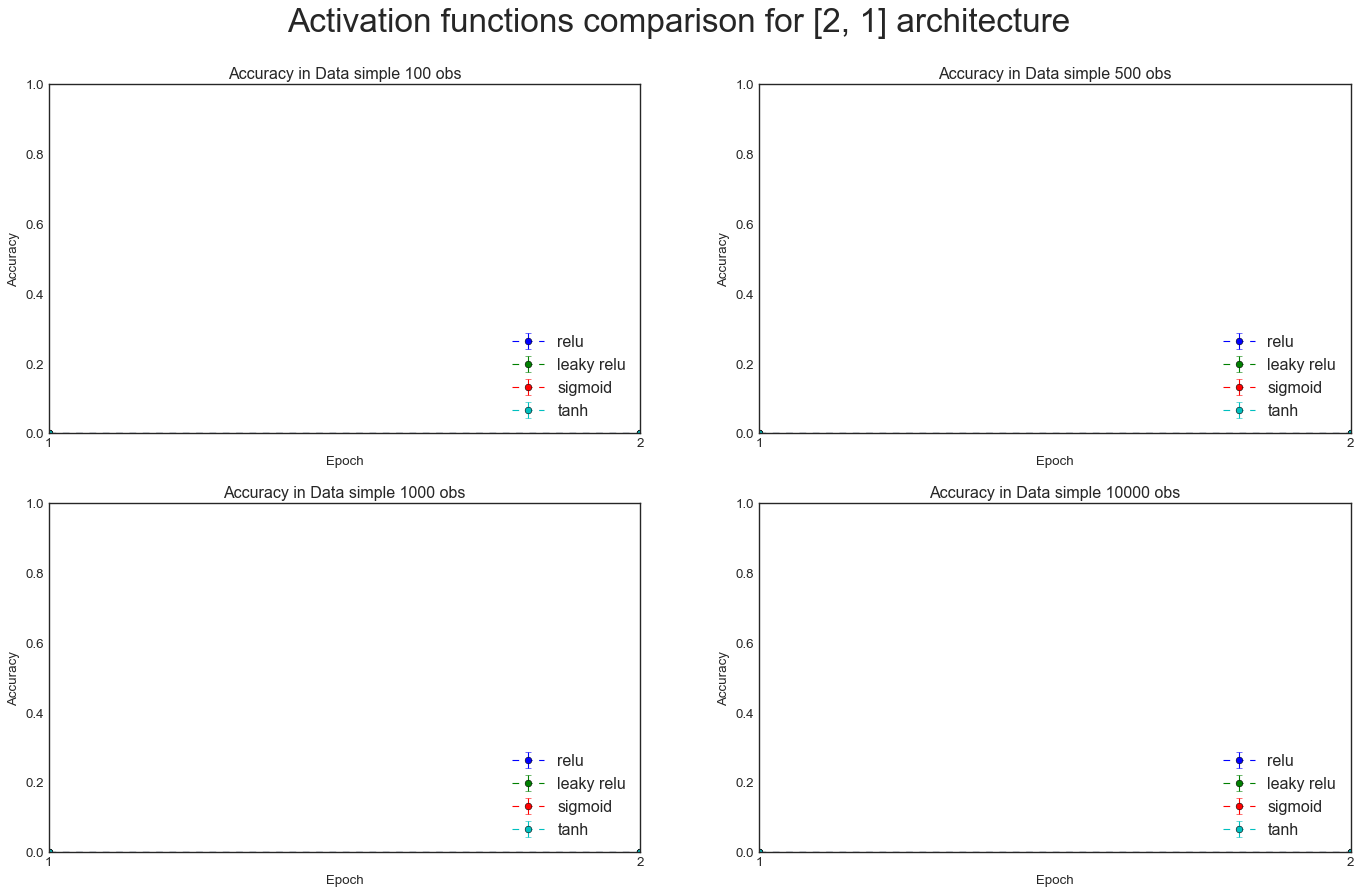

In [11]:
visualize_experiment(ans['activation_function'],
                     title='Activation functions comparison for {} architecture'.format(str(experiment_dict['neuron_numbers'])))

(                             beta=0      beta=0.5      beta=0.9
 Data simple 100 obs    0.00 +- 0.00  0.00 +- 0.00  0.00 +- 0.00
 Data simple 500 obs    0.00 +- 0.00  0.00 +- 0.00  0.00 +- 0.00
 Data simple 1000 obs   0.00 +- 0.00  0.00 +- 0.00  0.00 +- 0.00
 Data simple 10000 obs  0.00 +- 0.00  0.00 +- 0.00  0.00 +- 0.00,
 <Figure size 1680x960 with 4 Axes>)

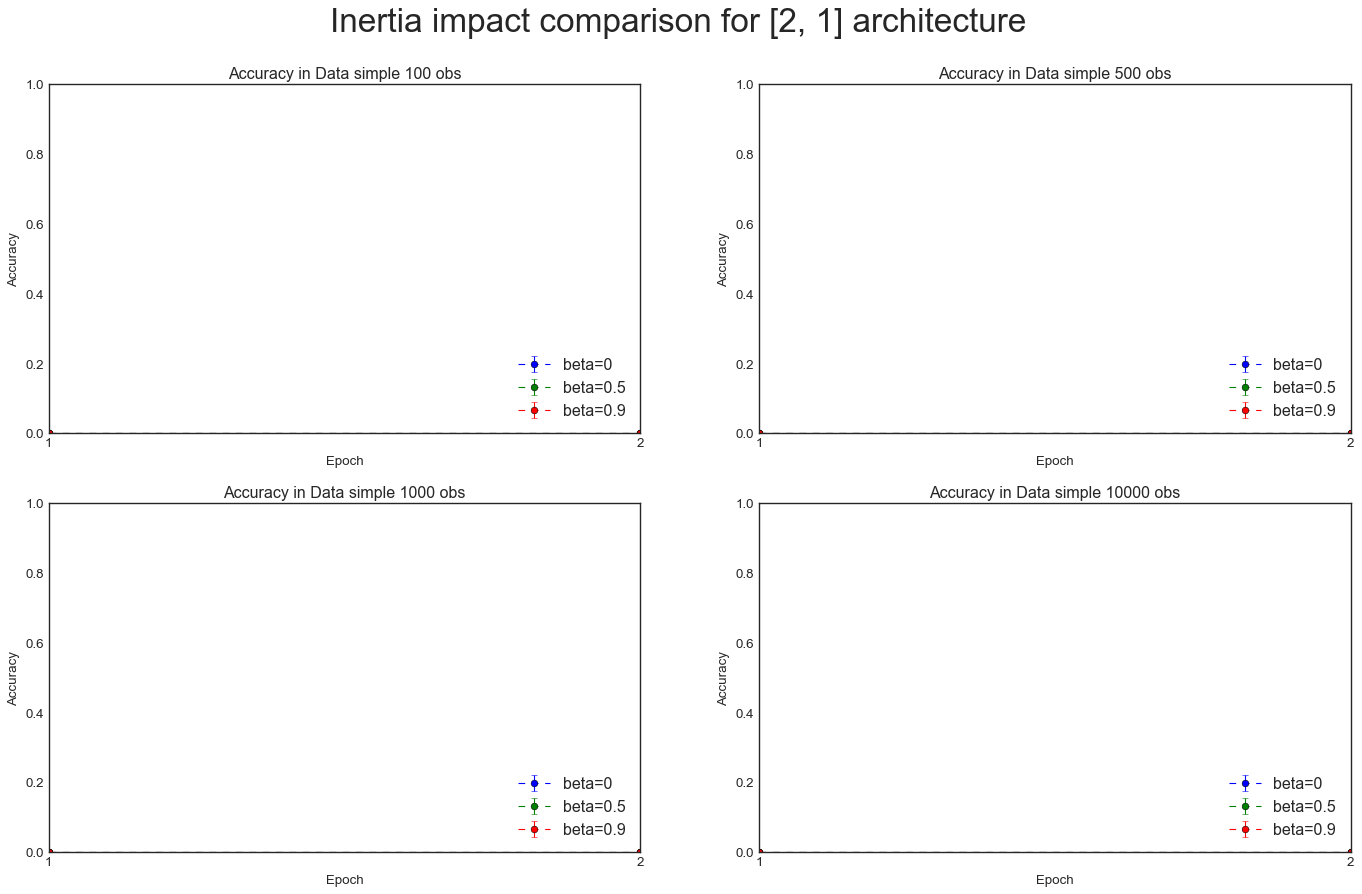

In [12]:
visualize_experiment(ans['inertia'],
                     title='Inertia impact comparison for {} architecture'.format(str(experiment_dict['neuron_numbers'])))

(                               bs=4         bs=16         bs=32         bs=64
 Data simple 100 obs    0.00 +- 0.00  0.00 +- 0.00  0.00 +- 0.00  0.00 +- 0.00
 Data simple 500 obs    0.00 +- 0.00  0.00 +- 0.00  0.00 +- 0.00  0.00 +- 0.00
 Data simple 1000 obs   0.00 +- 0.00  0.00 +- 0.00  0.00 +- 0.00  0.00 +- 0.00
 Data simple 10000 obs  0.00 +- 0.00  0.00 +- 0.00  0.00 +- 0.00  0.00 +- 0.00,
 <Figure size 1680x960 with 4 Axes>)

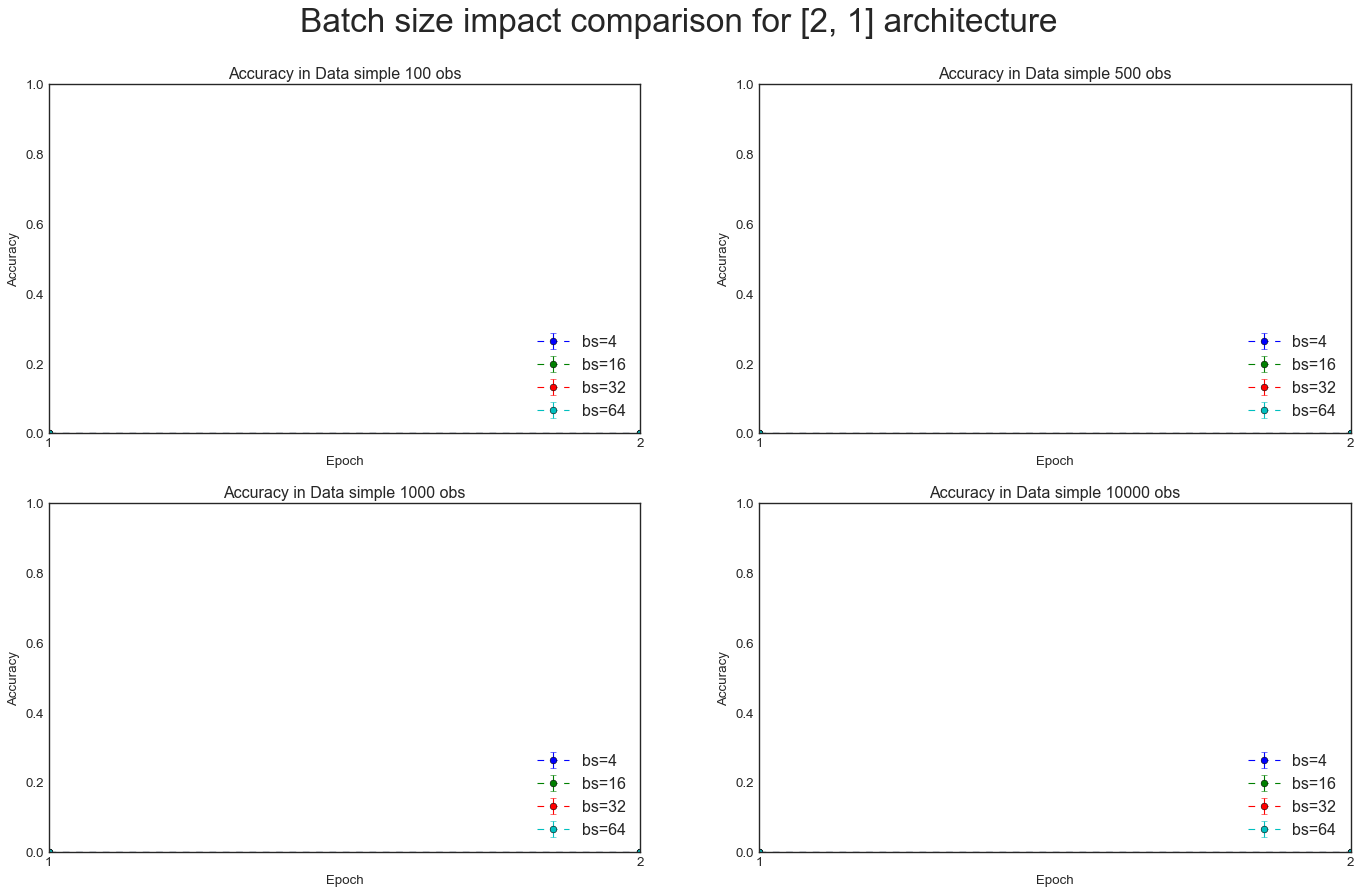

In [13]:
visualize_experiment(ans['batch_size'],
                     title='Batch size impact comparison for {} architecture'.format(str(experiment_dict['neuron_numbers'])))

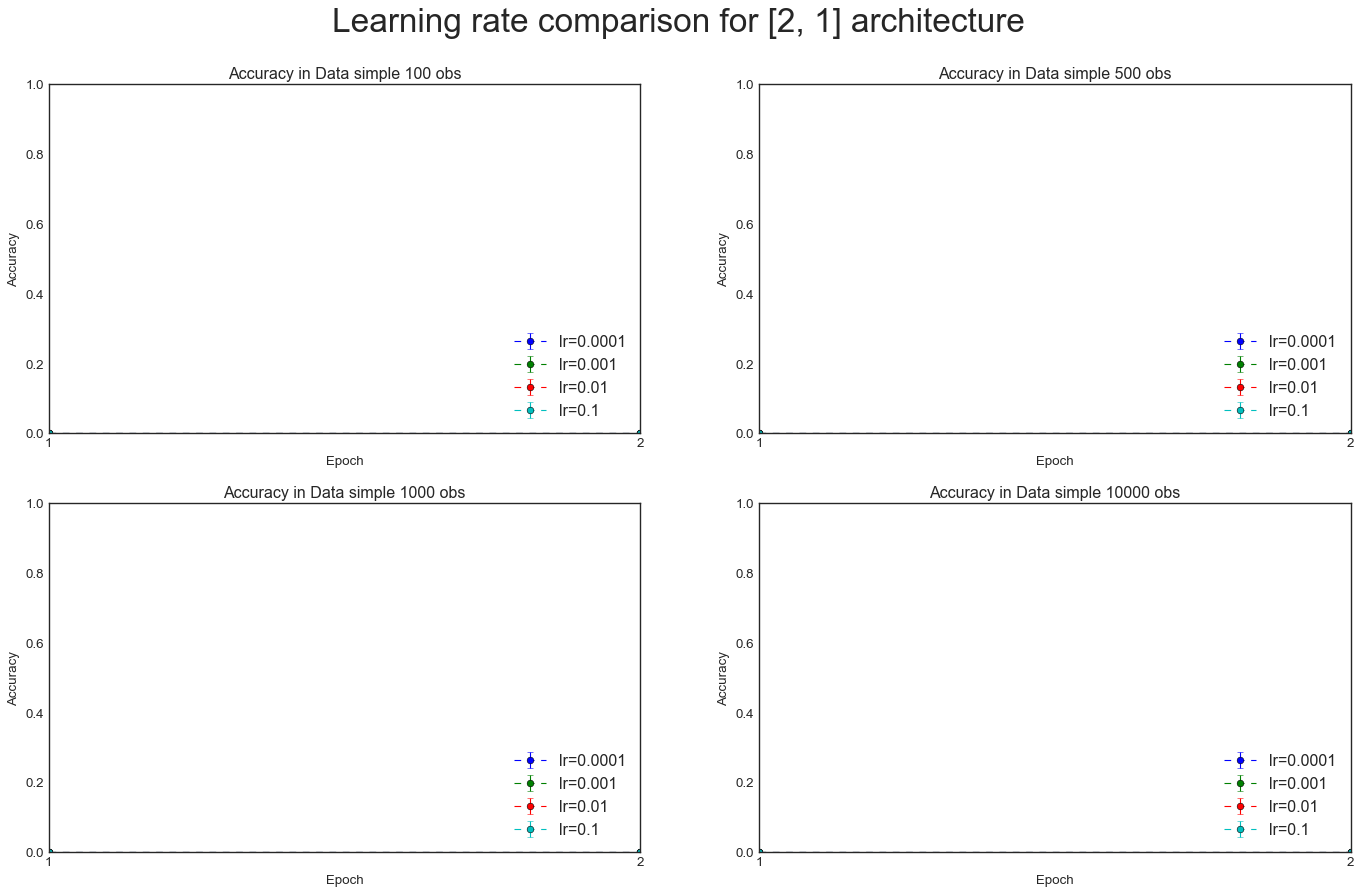

In [14]:
x = visualize_experiment(ans['lr'],
                     title='Learning rate comparison for {} architecture'.format(str(experiment_dict['neuron_numbers'])))

In [15]:
titles = {'lr' : 'Learning rate comparison for {} architecture'.format(str(experiment_dict['neuron_numbers'])),
         'activation_function' : 'Activation functions comparison for {} architecture'.format(str(experiment_dict['neuron_numbers'])),
         'inertia' : 'Inertia impact comparison for {} architecture'.format(str(experiment_dict['neuron_numbers'])),
         'batch_size' : 'Batch size impact comparison for {} architecture'.format(str(experiment_dict['neuron_numbers'])),}

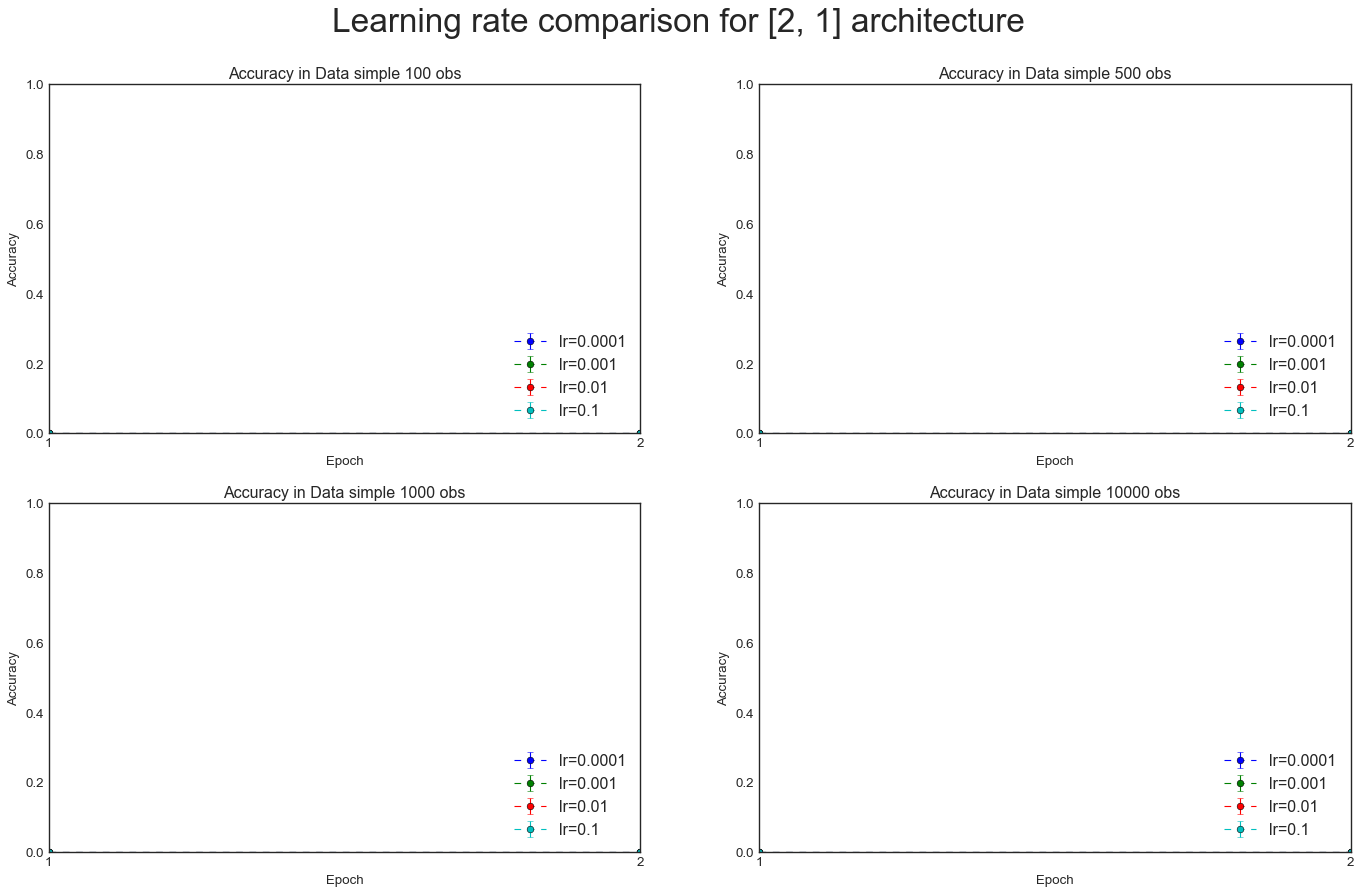

In [16]:
x = visualize_experiment(ans['lr'],
                     title='Learning rate comparison for {} architecture'.format(str(experiment_dict['neuron_numbers'])))

In [17]:
def visualize_experiment(d, title="", figsize=(21, 12)):

SyntaxError: unexpected EOF while parsing (<ipython-input-17-70462962cd22>, line 1)

In [ ]:
import datetime

def experiment_save_results(d, titles, path, figsize=(21, 12)):
    for exp_name, exp_results in d.items():
        output_table, fig = visualize_experiment(exp_results,
                                                titles[exp_name])
        with open(os.path.join(path, exp_name + "_" + datetime.datetime.today().strftime("%Y_%m_%d_%H_%M_%S") + "_" + ".txt"),
                  "w") as text_file:
            text_file.write(output_table.to_latex())
           
        print(os.path.join(path, exp_name + "_" + datetime.datetime.today().strftime("%Y_%m_%d_%H_%M_%S") + "_" + ".txt"))
        fig.savefig(os.path.join(path,
                                 exp_name + "_" + datetime.datetime.today().strftime("%Y_%m_%d_%H_%M_%S") + ".png"))

In [ ]:
experiment_save_results(ans, titles, "./")

In [ ]:
data_gauss_train_100 = pd.read_csv("./projekt1/classification/data.three_gauss.train.100.csv")
data_gauss_train_500 = pd.read_csv("./projekt1/classification/data.three_gauss.train.500.csv")
data_gauss_train_1000 = pd.read_csv("./projekt1/classification/data.three_gauss.train.1000.csv")
data_gauss_train_10000 = pd.read_csv("./projekt1/classification/data.three_gauss.train.10000.csv")

data_gauss_test_100 = pd.read_csv("./projekt1/classification/data.three_gauss.test.100.csv")
data_gauss_test_500 = pd.read_csv("./projekt1/classification/data.three_gauss.test.500.csv")
data_gauss_test_1000 = pd.read_csv("./projekt1/classification/data.three_gauss.test.1000.csv")
data_gauss_test_10000 = pd.read_csv("./projekt1/classification/data.three_gauss.test.10000.csv")

In [ ]:
data_gauss_train_100

In [ ]:
data

In [18]:
def eval_accuracy(y_true, y_pred):
    if y_true.ndim > 1:
        return np.sum(np.sum(np.equal(y_true, y_pred), axis=1)) / y_true.shape[0]
    else:
        print(y_true)
        print(y_pred)
        return np.sum(np.all(np.equal(y_true, y_pred))) / y_true.shape[0]

In [26]:
y = np.array([0, 1, 0, 1])
y_hat = np.array([0, 1, 1, 1])

In [27]:
eval_accuracy(y, y_hat)

[0 1 0 1]
[0 1 1 1]


0.0

In [31]:
np.sum(np.equal(y, y_hat))

3